# Análise comparativa da proteína Citocromo B em espécies de *Leishmania* e outros organismos

Micheli Ferla e Joana Marques

## [J] Introdução e objetivo

***Introdução:***

A leishmaniose é uma doença causada pelo parasita do género *Leishmania*

Citocromo B: proteína que transporta elétrons e gera o gradiente de prótons para síntese de ATP

Em *Leishmania*, o gene *cyt b* está localizado no cinetoplasto, tem cerca de 1080 pb e é rico em AT

Escolhemos o gene da proteína citocromo b:

* é altamente conservado entre eucariotos
* amplamente disponível em bases públicas
* apresenta tamanho relativamente constante


***Objetivo:***

Comparar sequências da proteína citocromo b em diferentes espécies de *Leishmania*, analisando suas características e relações filogenéticas com outros organismos

## Implementação

### [M] Parte 0. Carregar drive e instalar bibliotecas necessárias.

In [1]:
!pip install biopython
!pip install pandas
!pip install matplotlib

from google.colab import drive
drive.mount('/content/drive')

from Bio import SeqIO
import pandas as pd
import matplotlib.pyplot as plt

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### [M] Parte 1. Carregar e limpar o data set.

Obtivemos o data set buscando em https://www.ncbi.nlm.nih.gov/nuccore/ pela seguinte busca:

``"Leishmania"[Organism] AND ("cytb" OR "cyt b") AND 1000:1200[SLEN] NOT partial ``

https://www.ncbi.nlm.nih.gov/nuccore/?term=%22Leishmania%22%5BOrganism%5D+AND+(%22cytb%22+OR+%22cyt+b%22)+AND+1000%3A1200%5BSLEN%5D+NOT+partial

O data set é guardado no arquivo Leishmania.fasta e contém sequências para várias espécies de *Leishmania*.

O código a seguir carrega o arquivo.

In [2]:
records = SeqIO.parse("/content/drive/My Drive/Python_Ciencias_Biom/Projeto/Leishmania.fasta", "fasta")
records = list(records)
print(f"{len(records)} records lidos.\n")

# Printa descrição de cada sequência.
for r in records:
  print(r.description)

46 records lidos.

AB434684.1 Leishmania deanei kinetoplast pre-edited Cytb gene for cytochrome b, strain: MCOE/BR/74/M2674
AB434679.1 Leishmania pifanoi kinetoplast pre-edited Cytb gene for cytochrome b, strain: MHOM/VE/57/LL1
AB434678.1 Leishmania aristidesi kinetoplast pre-edited Cytb gene for cytochrome b, strain: MORY/PA/69/GML
AB434677.1 Leishmania donovani archibaldi kinetoplast pre-edited Cytb gene for cytochrome b, strain: MHOM/ET/72/GEBRE1
AB095970.1 Leishmania cf. major kinetoplast pre-edited version of Cytb gene for cytochrome b
AB095964.1 Leishmania amazonensis kinetoplast pre-edited version of Cytb gene for cytochrome b
AB095963.1 Leishmania mexicana mexicana kinetoplast pre-edited version of Cytb gene for cytochrome b
AB095962.1 Leishmania aethiopica kinetoplast pre-edited version of Cytb gene for cytochrome b
AB095961.1 Leishmania major kinetoplast pre-edited version of Cytb gene for cytochrome b
AB095960.1 Leishmania tropica kinetoplast pre-edited version of Cytb gene 

No data set, as descrições são do tipo:

"``AB434684.1 Leishmania deanei kinetoplast pre-edited Cytb gene for cytochrome b, strain: MCOE/BR/74/M2674``".

Queremos apenas a espécie (ignorando subespécie, para simplificar) pegando a terceira palavra da string description.

Criamos uma função `get_species_name` para facilitar o processo.

In [3]:
# Função que recebe um record r e retorna a espécie.
def get_species_name(r):
  return "Leishmania " + r.description.split(' ')[2]

# Printa todos nomes de espécies e tamanhos.
for r in records:
  print(len(r.seq), 'bp -', get_species_name(r))

1079 bp - Leishmania deanei
1079 bp - Leishmania pifanoi
1078 bp - Leishmania aristidesi
1079 bp - Leishmania donovani
1080 bp - Leishmania cf.
1078 bp - Leishmania amazonensis
1079 bp - Leishmania mexicana
1080 bp - Leishmania aethiopica
1080 bp - Leishmania major
1080 bp - Leishmania tropica
1080 bp - Leishmania donovani
1079 bp - Leishmania donovani
1079 bp - Leishmania donovani
1080 bp - Leishmania tropica
1079 bp - Leishmania donovani
1079 bp - Leishmania donovani
1079 bp - Leishmania infantum
1078 bp - Leishmania mexicana
1080 bp - Leishmania tropica
1080 bp - Leishmania equatorensis
1080 bp - Leishmania equatorensis
1080 bp - Leishmania arabica
1080 bp - Leishmania enriettii
1078 bp - Leishmania braziliensis
1078 bp - Leishmania braziliensis
1078 bp - Leishmania shawi
1080 bp - Leishmania killicki
1080 bp - Leishmania turanica
1080 bp - Leishmania arabica
1078 bp - Leishmania guyanensis
1078 bp - Leishmania panamensis
1078 bp - Leishmania braziliensis
1078 bp - Leishmania brazil

Olhando a lista printada acima, identificamos algumas características:

- algumas espécies repetidas (queremos apenas uma sequência por espécie).
- algumas espécies indefinidas (sp. ou cf.).
- uma sequência com tamanho fora do padrão (1060 - *Leishmania sp.*), possivelmente indicando um outlier ou uma sequência incompleta.

O código a seguir limpa o data set considerando os pontos acima. Especificamente:
- remove sp., cf.
- remove duplicadas.
- remove sequências com tamanho fora do normal.

In [4]:
new_records = []   # nova lista de records (substituirá a antiga), inicialmente vazia
names_set = set()  # set de strings com todos nomes, inicialmente vazio

for record in records: # Para cada record:

  # Pega nome da espécie usando get_species_name.
  species_name = get_species_name(record)

  # Pula espécies genéricas (sp. ou cf.).
  if species_name.startswith("Leishmania sp") or species_name.startswith("Leishmania cf"):
    continue

  # Pula espécies repetidas.
  if species_name in names_set: # se species_name já foi visto, pula (lembrar que set elimina duplicatas)
    continue
  names_set.add(species_name) # (adiciona species_name ao set de nomes já vistos)

  # Pula sequências com tamanho fora do range aceitável, que definimos estar entre 1070 e 1090.
  if len(r.seq) < 1070 or len(r.seq) > 1090:
    continue

  # Ok - record passou os testes - adiciona à lista new_records.
  new_records.append(record)

No fim, substituimos a lista de sequências:

In [5]:
print(f'Mantidos {len(new_records)} de {len(records)} records originalmente.\n')

# Coloca new_records em records.
records = new_records

# Printa todos nomes de espécies e tamanhos na lista records.
for r in records:
  print(len(r.seq), 'bp -', get_species_name(r))

Mantidos 21 de 46 records originalmente.

1079 bp - Leishmania deanei
1079 bp - Leishmania pifanoi
1078 bp - Leishmania aristidesi
1079 bp - Leishmania donovani
1078 bp - Leishmania amazonensis
1079 bp - Leishmania mexicana
1080 bp - Leishmania aethiopica
1080 bp - Leishmania major
1080 bp - Leishmania tropica
1079 bp - Leishmania infantum
1080 bp - Leishmania equatorensis
1080 bp - Leishmania arabica
1080 bp - Leishmania enriettii
1078 bp - Leishmania braziliensis
1078 bp - Leishmania shawi
1080 bp - Leishmania killicki
1080 bp - Leishmania turanica
1078 bp - Leishmania guyanensis
1078 bp - Leishmania panamensis
1079 bp - Leishmania garnhami
1080 bp - Leishmania gerbilli


### Parte 2. Calcular algumas estatísticas sobre o data set das *Leishmanias*.

Agora vamos calcular e mostrar algumas estatísticas sobre este data set, usando as bibliotecas `pandas` e `matplotlib`.

#### [J] 2.1 - Histograma de tamanhos de sequências.

Primeiramente, calculamos um histograma de tamanhos de sequências. (Para cada tamanho, o número de ocorrências.)

[1079, 1079, 1078, 1079, 1078, 1079, 1080, 1080, 1080, 1079, 1080, 1080, 1080, 1078, 1078, 1080, 1080, 1078, 1078, 1079, 1080]


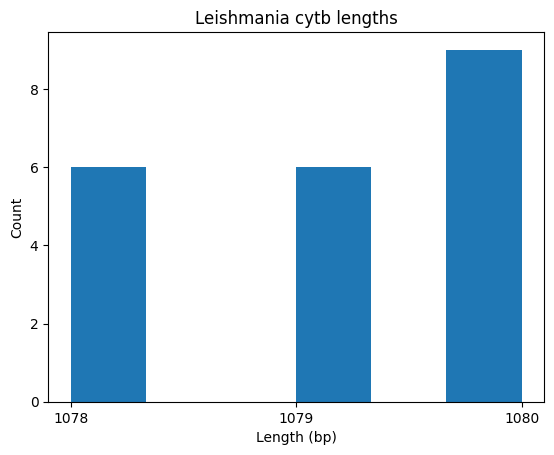

In [6]:
# Cria lista com todos tamanhos de sequência.
lengths = [len(r.seq) for r in records] # (list comprehension)

print(lengths)

# Criar histograma com matplotlib.
plt.hist(lengths, bins='auto')
plt.xlabel('Length (bp)')
plt.ylabel('Count')
plt.title('Leishmania cytb lengths')
plt.xticks(list(set(lengths))) # Usa exatamente os tamanhos na lista como labels do eixo x.
# plt.yticks(list(range(12)))
plt.show()

#### [J] 2.2 - Visualizando porcentagem GC das Leishmanias.

Primeiramente, definimos uma função auxiliar para calcular a percentagem GC de um record (sequência). Depois, calculamos a percentagem GC para todos records.

In [7]:
# Definição de função que recebe um record (sequência) e calcula a porcentagem de GC.
def gc_percent(r):
  return 100.0 * (r.seq.count("G") + r.seq.count("C")) / len(r.seq)

# Cria uma lista com todas porcentagens.
gc = [gc_percent(r) for r in records]

print(f"Porcentagens GC: {gc}")
print(f"Média: {sum(gc) / len(gc)}")
print(f"Máximo: {max(gc)}")
print(f"Mínimo: {min(gc)}")

Porcentagens GC: [25.949953660797036, 23.076923076923077, 22.820037105751393, 23.725671918443002, 22.448979591836736, 23.076923076923077, 24.166666666666668, 24.537037037037038, 23.98148148148148, 23.540315106580167, 22.77777777777778, 25.833333333333332, 23.425925925925927, 21.428571428571427, 21.05751391465677, 24.166666666666668, 25.555555555555557, 21.428571428571427, 21.70686456400742, 22.335495829471732, 25.64814814814815]
Média: 23.461353014053614
Máximo: 25.949953660797036
Mínimo: 21.05751391465677


Então, geramos o gráfico (bar plot).

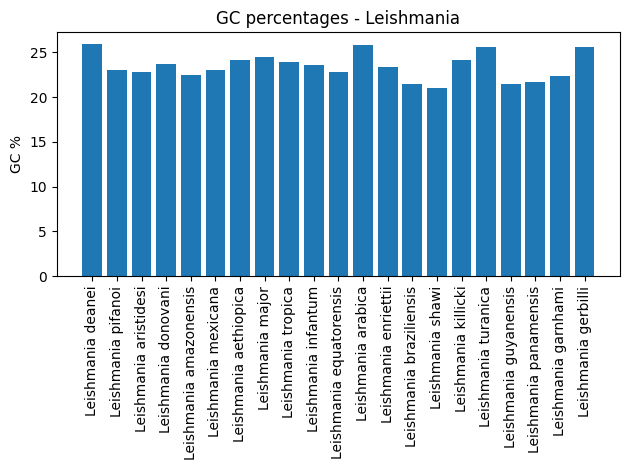

In [8]:
# Primeiramente, criamos lista de nomes para usar como labels no eixo x do gráfico.
species_names = [get_species_name(r) for r in records]

plt.bar(range(len(records)), gc)
plt.xticks(range(len(records)), species_names, rotation=90) # Usando rotation=90 para visualizar nomes na vertical.
plt.ylabel("GC %")
plt.title("GC percentages - Leishmania")
plt.tight_layout() # Necessário para evitar que nomes fiquem fora da imagem gerada.
plt.show()

A elevada proporção de AT no gene citocromo b em Leishmania:

* Provoca um viés na utilização de códões e aumenta a frequência de mutações (A-T), podendo interferir nas análises filogenéticas
* Favorece inserções e deleções (indels), devido à instabilidade durante a replicação do DNA

#### [M] 2.3 - Alinhamento de sequência entre pares de espécies de *Leishmania*.

Neste passo, vamos alinhar pares de sequência de diferentes espécies de *Leishmania*.

Como temos muitas espécies, para facilitar a visualização, vamos filtrar um pouco mais a nossa lista, para manter só algumas.

In [9]:
# Cria um set de nomes de espécie para manter.
keep_set = {
  "Leishmania donovani",
  "Leishmania major",
  "Leishmania tropica",
  "Leishmania infantum",
  "Leishmania amazonensis",
  "Leishmania shawi",
  "Leishmania guyanensis",
}
# Recria a lista records, mantendo apenas aqueles que estão no set acima.
records = [r for r in records if get_species_name(r) in keep_set]

# Recria a lista dos nomes das espécies, para usar no gráfico.
species_names = [get_species_name(r) for r in records]

Agora, importamos e inicializamos a função PairwiseAligner do Biopython para fazer os alinhamentos. (Código obtido da internet para referência.)

In [10]:
from Bio.Align import PairwiseAligner

# Define estrutura PairwiseAligner que será utilizada para alinhar.
align = PairwiseAligner()
align.mode = "global"
align.match_score = 1
align.mismatch_score = 0
align.open_gap_score = align.extend_gap_score = -1

# Definimos uma função auxiliar que calcula o score do alinhamento entre sequências a e b, em porcentagem relativa.
def align_score(a, b):
  return 100.0 * align.score(a.seq, b.seq) / len(a.seq)

Então, criamos uma matriz (representado por uma lista de listas) e um pandas DataFrame que contém o alinhamento de todos pares de espécies.

In [11]:
# Cria matriz 2D (lista de listas) com todos os scores entre pares de records.
score_matrix = [[align_score(a, b) for a in records] for b in records] # lista de listas

# Converte para DataFrame.
df = pd.DataFrame(score_matrix) # transforma listas para data frame

A seguir, plotamos a matriz em formato heatmap usando a função `imshow` do matplotlib.

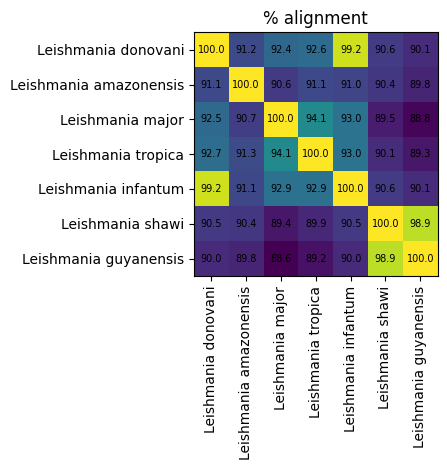

In [12]:
plt.imshow(df.values)
plt.xticks(range(len(records)), species_names, rotation=90)
plt.yticks(range(len(records)), species_names)
plt.title("% alignment")

# Colocar valor de cada célula como texto, para facilitar visualização.
for a in range(len(records)):
    for b in range(len(records)):
        plt.text(b, a, f"{score_matrix[a][b]:.1f}", ha="center", va="center", fontsize=7)

plt.tight_layout() # Para caber tudo na imagem.
plt.show()

### [M] Parte 3. Comparar sequência da *Leishmania infantum* com a sequência de outros organismos.

Nesta parte, achamos que seria interessante re-executar o passo anterior (2.3), mas desta vez comparando a *Leishmania* com outros organismos:
- *Leishmania infantum*
- *Plasmodium falciparum* (malária)
- *Drosophila melanogaster* (mosca-da-fruta)
- *Mus musculus* (ratinho)
- *Homo sapiens* (humano)

A ideia é criar uma "escada evolutiva" de organismos que são progressivamente mais diferentes da Leishmania.

Novamente, todas sequências foram obtidas do site https://www.ncbi.nlm.nih.gov/nuccore/.

In [13]:
# Define lista de nomes das espécies.
species_names = [
  "Leishmania infantum",
  "Plasmodium falciparum",
  "Mus musculus",
  "Homo sapiens",
  "Drosophila melanogaster"
]

# Define lista de nomes de arquivos para baixar.
files = [
  "/content/drive/My Drive/Python_Ciencias_Biom/Projeto/Leishmania_infantum.fasta",
  "/content/drive/My Drive/Python_Ciencias_Biom/Projeto/Plasmodium_falciparum.fasta",
  "/content/drive/My Drive/Python_Ciencias_Biom/Projeto/Mus_musculus.fasta",
  "/content/drive/My Drive/Python_Ciencias_Biom/Projeto/Homo_sapiens.fasta",
  "/content/drive/My Drive/Python_Ciencias_Biom/Projeto/Drosophila_melanogaster.fasta",
]

# Código para ler todos records.

records = []
for filename in files:
  r = SeqIO.read(filename, "fasta")
  records.append(r)

Agora, executamos exatamente o mesmo código da seção 2.3 (geração da matriz e do heatmap).

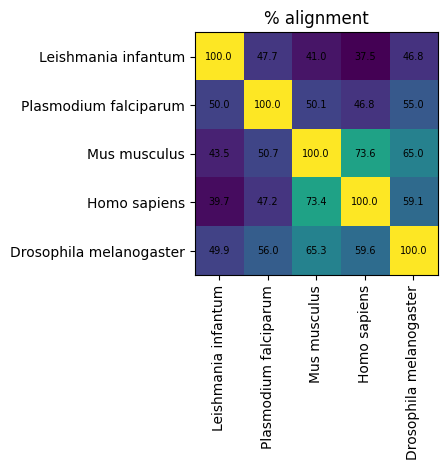

In [14]:
# (copy-and-paste do código anterior da seção 2.3)

score_matrix = [[align_score(a, b) for a in records] for b in records]
df = pd.DataFrame(score_matrix)

plt.imshow(df.values)
plt.xticks(range(len(records)), species_names, rotation=90)
plt.yticks(range(len(records)), species_names)
plt.title("% alignment")

# Colocar valor de cada célula como texto, para facilitar visualização.
for a in range(len(records)):
    for b in range(len(records)):
        plt.text(b, a, f"{score_matrix[a][b]:.1f}", ha="center", va="center", fontsize=7)

plt.tight_layout() # Para caber tudo na imagem.
plt.show()

## Referências

1. Pace D. Leishmaniasis. J Infect. 2014 Nov;69 Suppl 1:S10-8. doi: 10.1016/j.jinf.2014.07.016. Epub 2014 Sep 17. PMID: 25238669.
2. F Turrens J, Alexandre A, L Lehninger A. Reprint of: Ubisemiquinone Is the Electron Donor for Superoxide Formation by Complex III of Heart Mitochondria. Arch Biochem Biophys. 2022 Sep 15;726:109232. doi: 10.1016/j.abb.2022.109232. Epub 2022 Jun 2. PMID: 35660297.
3. Foulet F, Botterel F, Buffet P, Morizot G, Rivollet D, Deniau M, Pratlong F, Costa JM, Bretagne S. Detection and identification of Leishmania species from clinical specimens by using a real-time PCR assay and sequencing of the cytochrome B gene. J Clin Microbiol. 2007 Jul;45(7):2110-5. doi: 10.1128/JCM.02555-06. Epub 2007 May 2. PMID: 17475750; PMCID: PMC1932983.